In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable, grad
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyDOE import lhs
from utils import *
import time


In [2]:
class PhysicsInformedNN(nn.Module):

    def __init__(self, layers_u, layers_K):
        super(PhysicsInformedNN, self).__init__()
    
        self.layers = layers

        self.weights_u, self.biases_u = self.initialize_NN(layers_u)
        
        self.weights_K, self.biases_K = self.initialize_NN(layers_K)
        
        self.weights = self.weights_u + self.weights_K
        
        self.biases = self.biases_u + self.biases_K

        self.preds = None

        self.loss = None

        self.loss_list = []       
        
        self.optimizer = torch.optim.LBFGS(params=self.weights+self.biases,
                                            lr=0.00001, max_iter=5000, max_eval=5000,
                                         tolerance_grad=1e-07, tolerance_change=1e-08,
                                          history_size=100, line_search_fn=None)


    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = Variable(torch.zeros([1,layers[l+1]], dtype=torch.float32), requires_grad=True)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):

        return Variable(nn.init.xavier_normal_(torch.empty(size[0], size[1])), requires_grad=True)
    
    def neural_net(self, x, y, weights, biases):

        num_layers = len(weights) + 1
        H = torch.cat((x,y),1)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = torch.tanh(torch.add(torch.matmul(H, W), b))

        W = weights[-1]
        b = biases[-1]
        Y = torch.add(torch.matmul(H, W), b) #.requires_grad_()

        return Y

    def neural_net_sigmoid(self, x, y, weights, biases):

        num_layers = len(weights) + 1
        H = torch.cat((x,y),1)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = torch.sigmoid(torch.add(torch.matmul(H, W), b))

        W = weights[-1]
        b = biases[-1]
        Y = torch.add(torch.matmul(H, W), b) #.requires_grad_()

        return Y

    def net_u(self, x, y): # head u, including Dirichlet BCs
        u = self.neural_net(x, y, self.weights_u, self.biases_u)
        return u
    
    def net_K(self, x, y): # hydraulic conductivity K
        K = self.neural_net(x, y, self.weights_K, self.biases_K)
        return K
    
    def net_du(self, x, y): # first-order derivative match, inlcuding Neumann BCs

        u = self.net_u(x, y)#, self.weights_u, self.biases_u)

        u_x = grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
        u_y = grad(u.sum(), y, create_graph=True)[0]

        return u_x.requires_grad_(True), u_y.requires_grad_(True)

    def net_f(self, x, y): # general PDE match, usually formulated in higher-order

        K = self.net_K(x, y)
        
        u_x, u_y = self.net_du(x, y)

        u_yy = grad(u_y.sum(), y, create_graph=True)[0]

        u_xx = grad(u_x.sum(), x, create_graph=True)[0]

        f = K*(u_yy + u_xx)

        return f.requires_grad_(True)

    def forward(self, x_tensors, y_tensors, keys=None):

        if keys is None:
            keys = x_tensors.keys()
        else:
            preds = dict()
            for i in keys:
                preds[i] = None

        for i in keys:

            if i == 'nuem':
                dudx_pred, _ = self.net_du(x_tensors[i], y_tensors[i])
                preds[i] = dudx_pred

            elif i == 'f':
                f_pred = self.net_f(x_tensors[i], y_tensors[i])
                preds[i] = f_pred

            elif i == 'u':
                u_pred = self.net_u(x_tensors[i], y_tensors[i]) 
                preds[i] = u_pred
                
            elif i == 'K':
                K_pred = self.net_K(x_tensors[i], y_tensors[i]) 
                preds[i] = K_pred
                
            elif i == 'diri':
                diri_pred = self.net_u(x_tensors[i], y_tensors[i])   
                preds[i] = diri_pred

        return preds

    def loss_func(self, pred_dict, true_dict, weights=None):
    
        loss = torch.tensor(0.0, dtype=torch.float32)
        keys = pred_dict.keys()

        if weights is None:
            weights = dict()
            for i in keys:
                weights[i] = 1.0

        for i in keys:
            res = pred_dict[i] - true_dict[i]
            loss += weights[i]*torch.mean(res.pow(2))

        return loss.requires_grad_()
    
    def customized_backward(self, loss, params):
        grads = grad(loss, params, retain_graph=True)
        for vid in range(len(params)):
            params[vid].grad = grads[vid]
        return grads

    def unzip_train_dict(self, train_dict, keys=None):
        if keys is None:
            keys = train_dict.keys()

        x_tensors = dict()
        y_tensors = dict()
        true_dict = dict()

        for i in keys:
            x_tensors[i] = train_dict[i][0]
            y_tensors[i] = train_dict[i][1]
            true_dict[i] = train_dict[i][2]

        return (x_tensors, y_tensors, true_dict)

    def train_LBFGS(self, train_dict, loss_func, optimizer):

        (x_tensors, y_tensors, true_dict) = self.unzip_train_dict(train_dict)

        def closure():

            optimizer.zero_grad()
            pred_dict = self.forward(x_tensors, y_tensors, keys=('diri', 'nuem', 'f', 'u','K'))
            loss = loss_func(pred_dict, true_dict)
            
            # g = self.customized_backward(loss, self.weights+self.biases)
            loss.backward()
            self.callback(loss.detach().numpy().squeeze())
            if np.remainder(len(self.loss_list),100) == 0:
                print('Iter #', len(self.loss_list), 'Loss:', self.loss_list[-1])
            return loss

        optimizer.step(closure)

        self.pred_dict = self.forward(x_tensors, y_tensors, keys=('diri', 'nuem', 'f'))
        # self.loss = loss_func(self.pred_dict, true_dict) #.requires_grad_()

    def train(self, epoch, u_data, f_data, bc_data, loss_func, optimizer):
        (x_tensors, y_tensors, true_dict) = self.unzip_train_dict(train_dict)


        for i in range(epoch):
            optimizer.zero_grad()
            pred_dict = self.forward(x_tensors, y_tensors, keys=('diri', 'nuem', 'f'))
            loss = loss_func(pred_dict, true_dict) #.requires_grad_()
            
            self.callback(loss)
            if np.remainder(len(self.loss_list),100) == 0:
                print('Iter #', len(self.loss_list), 'Loss:', self.loss_list[-1].detach().numpy().squeeze())
            
            g = self.customized_backward(loss, self.weights+self.biases)
            # loss.backward()

  
            optimizer.step()

        self.pred_dict = self.forward(x_tensors, y_tensors)
        self.loss = loss_func(self.pred_dict, true_dict) #.requires_grad_()

    def callback(self, loss):
        self.loss_list.append(loss)

    def coor_shift(self, X, lbs, ubs):

        return 2.0*(X - lbs) / (ubs - lbs) - 1

    def data_loader(self, X, u, lbs, ubs):
                
        X = self.coor_shift(X, lbs, ubs)

        x_tensor = torch.tensor(X[:,0:1], requires_grad=True, dtype=torch.float32)
        y_tensor = torch.tensor(X[:,1:2], requires_grad=True, dtype=torch.float32)

        u_tensor = torch.tensor(u, dtype=torch.float32)
        
        return (x_tensor, y_tensor, u_tensor)

    def predict(self, X_input):
        x_tensor = torch.tensor(X_input[:,0:1], dtype=torch.float32)
        y_tensor = torch.tensor(X_input[:,1:2], dtype=torch.float32)
        return self.neural_net(x_tensor, y_tensor, self.weights_u, self.biases_u).detach().numpy().squeeze()
    
    def predict_K(self, X_input):
        x_tensor = torch.tensor(X_input[:,0:1], dtype=torch.float32)
        y_tensor = torch.tensor(X_input[:,1:2], dtype=torch.float32)
        return self.neural_net(x_tensor, y_tensor, self.weights_K, self.biases_K).detach().numpy().squeeze()


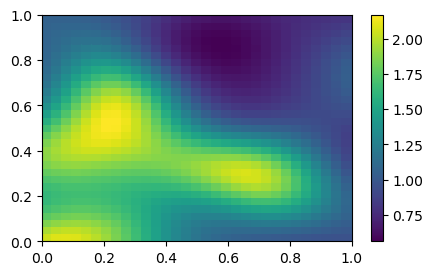

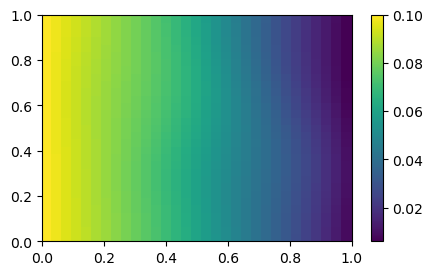

In [3]:
df=pd.read_csv('D:/research/inverse_code/sample/sample21/data/fields_0117.csv', sep=',',header=None)
mu = df.values[0][0]
sigma2 = df.values[0][1]
lx = df.values[0][2]
ly = df.values[0][3]
k = int(df.values[0][4])
alpha = df.values[1:k+1]
logK = df.values[k+1:]
df2=pd.read_csv('D:/research/inverse_code/sample/sample21/data/heads_0117.csv', sep=',',header=None)
heads = df2.values

ii = 7
head = heads[:,ii]
K = np.exp(logK[:,ii])

nx, ny = 32, 32
head = head.reshape((nx,ny))
K = K.reshape((nx,ny))

x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)

X, Y = np.meshgrid(x,y)
X, Y = Y, X

# plot_3D(x,y,head, 'Prediction')
# plot_3D(x,y,K, 'True')


fig = plt.figure(figsize=(5,3), dpi=100)
plt.pcolor(X,Y,K)
plt.colorbar()

fig = plt.figure(figsize=(5,3), dpi=100)
plt.pcolor(X,Y,head)
plt.colorbar()

In [4]:
N_u = 100
N_f = 20*20
N_uc = 30

Exact = head

X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_star = Exact.flatten()[:,None]      
K_star = K.flatten()[:,None]      

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)    
lbs = np.array([0,0])
ubs = np.array([1,1])
    
# Dirichlet BCs (top, left, bottom bounds)
N_diri = 80 # No. of point for Dirichlet BCs

# top
xx1 = np.hstack((X[0:1,:].T, Y[0:1,:].T))
uu1 = Exact[0:1,:].T
# left
xx2 = np.hstack((X[:,0:1], Y[:,0:1]))
uu2 = Exact[:,0:1]
# bottom
xx3 = np.hstack((X[-1:,:].T, Y[-1:,:].T))
uu3 = Exact[-1:,:].T

X_diri_train = np.vstack([xx1, xx2, xx3])
diri_train = np.vstack([uu1, uu2, uu3])
X_diri_train, diri_train = random_choice_sample([X_diri_train, diri_train], N_diri)

# Neumann BCs (right bound)
N_nuem = 10  # No. of points for Neumann BCs

xx4 = np.hstack((X[:,-1:], Y[:,-1:]))
dudx4 = np.zeros((xx4.shape[0],1))
X_nuem_train, nuem_train = random_choice_sample([xx4, dudx4], N_nuem)

# direct measure head, besides known BCs
N_u = 100     # data match (direct measurement)
xx_u = np.hstack((X[1:-1,1:-1].flatten()[:,None], Y[1:-1,1:-1].flatten()[:,None]))
X_u_train, u_train = random_choice_sample([xx_u, np.expand_dims(Exact[1:-1,1:-1].flatten(), axis=1)], N_u)

# direct measure hydraulic conductivity, besides known BCs
N_K = 100     # data match (direct measurement)
xx_K = np.hstack((X[1:-1,1:-1].flatten()[:,None], Y[1:-1,1:-1].flatten()[:,None]))
X_K_train, K_train = random_choice_sample([xx_K, np.expand_dims(K[1:-1,1:-1].flatten(), axis=1)], N_K)

# formulated PDE data collocation
N_f = 500
X_f_train = lb + (ub-lb)*lhs(2, N_f)
# X_f_train = np.vstack((X_f_train, X_u_train))
f_train = np.zeros((X_f_train.shape[0],1))

In [13]:
BCs = [1]

layers = [2, 20, 20, 20, 20, 20, 20, 1]

model = PhysicsInformedNN(layers, layers)

u_data = model.data_loader(X_u_train, u_train, lbs, ubs)
f_data = model.data_loader(X_f_train, f_train, lbs, ubs)
nuem_data = model.data_loader(X_nuem_train, nuem_train, lbs, ubs)
diri_data = model.data_loader(X_diri_train, diri_train, lbs, ubs)
K_data = model.data_loader(X_K_train, K_train, lbs, ubs)

# key:(data, loss_eval_weight) -> data: (x,y,val)
train_dict = {
    'u': u_data,
    'f': f_data,
    'nuem': nuem_data,
    'diri': diri_data,
    'K': K_data
}

optimizer = torch.optim.LBFGS(params=model.weights_u+model.biases_u+model.weights_K+model.biases_K,
                                lr=0.001, max_iter=10000, #max_eval=4000,
                                tolerance_grad=1e-09, tolerance_change=1e-10,
                                history_size=10, line_search_fn=None)


# optimizer = torch.optim.Adam(model.weights+model.biases, lr=1e-5)


In [14]:
start_time = time.time() 
model.train_LBFGS(train_dict, model.loss_func, optimizer)
# model.train(1000, train_dict, model.loss_func, optimizer)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iter # 100 Loss: 0.614509
Iter # 200 Loss: 0.17638597
Iter # 300 Loss: 0.10900324
Iter # 400 Loss: 0.1012261
Iter # 500 Loss: 0.100363836
Iter # 600 Loss: 0.10003696
Iter # 700 Loss: 0.09981999
Iter # 800 Loss: 0.09965453
Iter # 900 Loss: 0.09947614
Iter # 1000 Loss: 0.099089414
Iter # 1100 Loss: 0.09469806
Iter # 1200 Loss: 0.07269421
Iter # 1300 Loss: 0.05503475
Iter # 1400 Loss: 0.04513699
Iter # 1500 Loss: 0.041757666
Iter # 1600 Loss: 0.0402023
Iter # 1700 Loss: 0.038714338
Iter # 1800 Loss: 0.037821367
Iter # 1900 Loss: 0.036422737
Iter # 2000 Loss: 0.03485955
Iter # 2100 Loss: 0.03388417
Iter # 2200 Loss: 0.033276487
Iter # 2300 Loss: 0.032530077
Iter # 2400 Loss: 0.03170766
Iter # 2500 Loss: 0.031059522
Iter # 2600 Loss: 0.030476213
Iter # 2700 Loss: 0.029257743
Iter # 2800 Loss: 0.028564833
Iter # 2900 Loss: 0.028208008
Iter # 3000 Loss: 0.027833814
Iter # 3100 Loss: 0.027602086
Iter # 3200 Loss: 0.027180463
Iter # 3300 Loss: 0.026813218
Iter # 3400 Loss: 0.02651044
Iter # 350

In [7]:
X_pred = model.coor_shift(X_star, lbs, ubs)
u_pred = model.predict(X_pred)
K_pred = model.predict_K(X_pred)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_K = np.linalg.norm(K_star-K_pred,2)/np.linalg.norm(u_star,2)

print('Error u: %e' % (error_u))    

Error u: 1.451075e+01


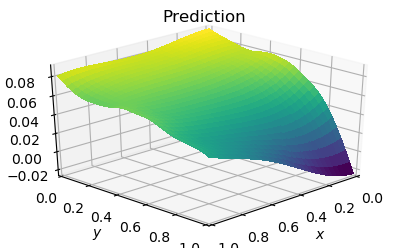

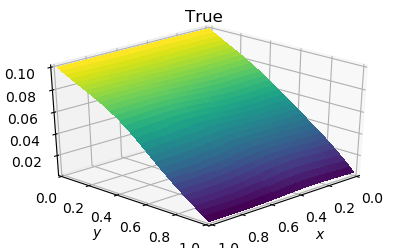

In [8]:
# np.savetxt('u_pred_torch.txt', u_pred)
# u_pred = np.loadtxt('u_pred_torch.txt').reshape((nx,ny))
u_pred = u_pred.reshape((nx,ny))
plot_3D(x,y,u_pred, 'Prediction')
plot_3D(x,y,Exact, 'True')
# plot_map_2d(x, y, Exact-u_pred, (nx,ny))
# compare_true_pred(Exact, u_pred, x, y)
plt.show()

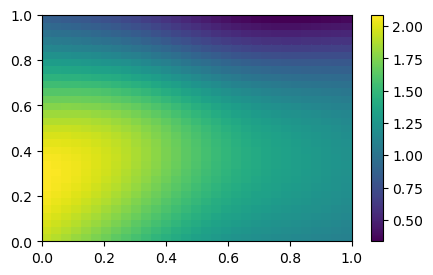

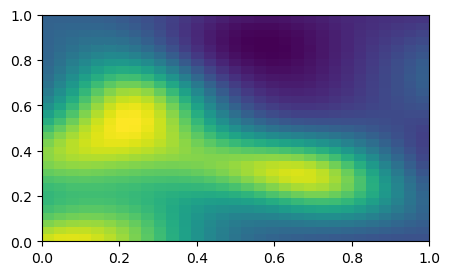

In [9]:
# np.savetxt('u_pred_torch.txt', u_pred)
# u_pred = np.loadtxt('u_pred_torch.txt').reshape((nx,ny))
K_pred = K_pred.reshape((nx,ny))

fig = plt.figure(figsize=(5,3), dpi=100)
plt.pcolor(X,Y,K_pred)
plt.colorbar()

fig = plt.figure(figsize=(5,3), dpi=100)
plt.pcolor(X,Y,K)

plt.show()